In [1]:
cd /opt/notebooks

/opt/notebooks


In [2]:
from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
import pandas as pd

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

warning in stationary: failed to import cython module: falling back to numpy


## Load Sample Data

In [3]:
signals_data = pd.read_csv('examples/sample_pennsignals_time_series.csv',parse_dates=['WCT'])

In [4]:
signals_data.head()

,WCT,Heart Rate (beats/min),BP Noninvasive Diastolic (mm Hg),BP Noninvasive Systolic (mm Hg)
0,2015-02-24 11:30:00,96.0,NaN,NaN
1,2015-02-24 12:00:00,100.0,87.0,138.0
2,2015-02-24 13:00:00,100.0,77.0,143.0
3,2015-02-24 14:00:00,97.0,79.0,138.0
4,2015-02-24 15:00:00,107.0,70.0,130.0


## Process the data into the format in the example

### Convert times to unit scale

In [5]:
signals_data['WCT'] = signals_data['WCT'].astype(int)
signals_data['WCT'] = (signals_data['WCT'] - signals_data['WCT'].min()) / (signals_data['WCT'].max() - signals_data['WCT'].min())

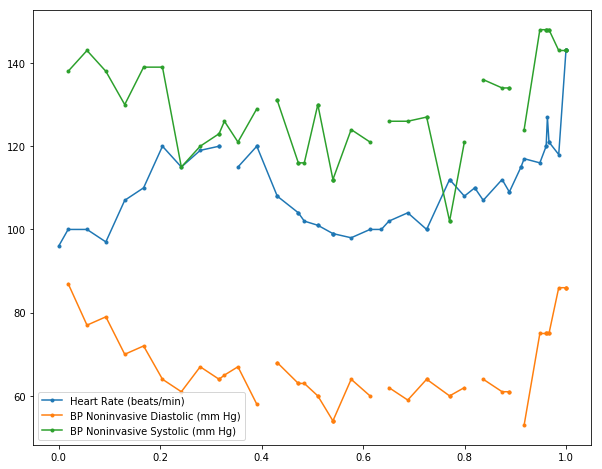

In [6]:
cvars = ['Heart Rate (beats/min)','BP Noninvasive Diastolic (mm Hg)','BP Noninvasive Systolic (mm Hg)']
fig, ax = plt.subplots(1,1,figsize=(10,8))
for c in cvars:
    ax.plot(signals_data.WCT,signals_data[c],'.-',label=c)
ax.legend(loc=0)

### Normalize to zero mean and unit variance

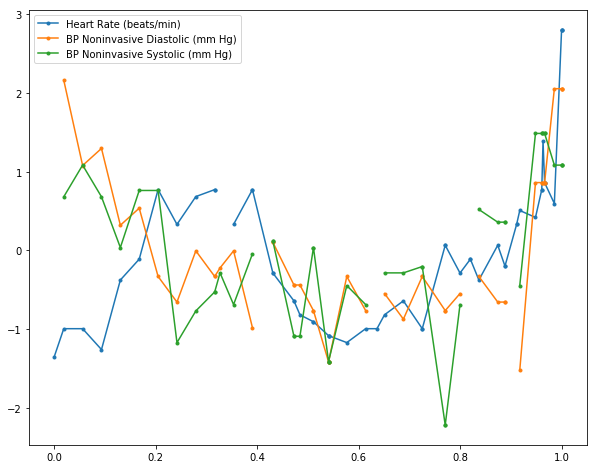

In [7]:
# Normalize
for c in cvars:
    signals_data[c] = (signals_data[c] - signals_data[c].mean()) / signals_data[c].std()
    
fig, ax = plt.subplots(1,1,figsize=(10,8))
for c in cvars:
    ax.plot(signals_data.WCT,signals_data[c],'.-',label=c)
ax.legend(loc=0)

### Remove duplicates since we can't have multipy y's at the same x.

In [8]:
xss = []
yss = []
for c in cvars:
    this_series = signals_data[['WCT',c]][pd.notnull(signals_data[c])]
    this_series.drop_duplicates(inplace=True)
    xss.append(this_series['WCT'].values)
    yss.append(this_series[c].values)

# Fit the Multi-Output GP

In [9]:
nout = len(yss)
ks = [RBF(name='rbf{}'.format(i)) for i in range(nout)]
n_per_output = [len(y) for y in yss]
n_per_output

[37, 34, 34]

In [10]:
def print_diagram(lmc):
    plot_xs =  np.arange(0, 1, 0.01)
    ys, var = lmc.predict([plot_xs for _ in range(nout)])
    for i, (y, v, xs, ys) in enumerate(zip(ys, var, xss, yss)):
        sd = np.sqrt(v)
        order = xs.argsort()
        plt.scatter(xs[order], ys[order])
        plt.title('output {} (95%)'.format(i))
        plt.plot(plot_xs, y)
        plt.plot(plot_xs, y + 2 * sd, ls='--', c='g')
        plt.plot(plot_xs, y - 2 * sd, ls='--', c='g')
        plt.show()

## Unoptimized

env: OMP_NUM_THREADS=1


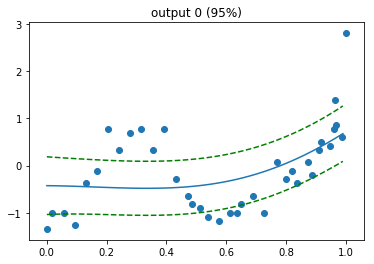

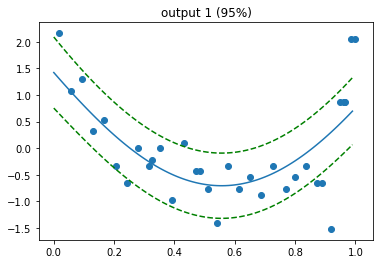

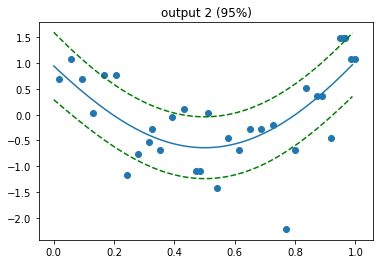

In [11]:
%env OMP_NUM_THREADS=1
lmc = LMC(xss, yss, kernels=ks)
print_diagram(lmc)

## Optimized

starting adadelta {'step_rate': 1, 'decay': 0.9, 'momentum': 0.5, 'offset': 0.0001, 'max_it': 100, 'verbosity': 10, 'min_grad_ratio': 0.1, 'permitted_drops': 5, 'callback': <function AdaDelta.noop at 0x7f6a47d1d6a8>}
iteration       10 grad norm 2.8837e+01
finished adadelta optimization
            19 iterations
    6.0416e+00 final grad norm
    norm used inf

Name : lmc
Objective : 126.0072240828816
Number of Parameters : 24
Number of Optimization Parameters : 24
Updates : True
Parameters:
  lmc.                  |          value  |  constraints  |  priors
  rbf0.inv_lengthscale  |  3.06192381958  |      +ve      |        
  rbf1.inv_lengthscale  |  1.91844577205  |      +ve      |        
  rbf2.inv_lengthscale  |  1.57397857564  |      +ve      |        
  a0                    |         (1, 3)  |               |        
  a1                    |         (1, 3)  |               |        
  a2                    |         (1, 3)  |               |        
  kappa0                |  

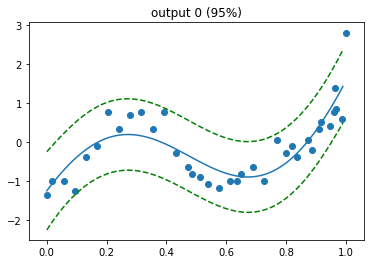

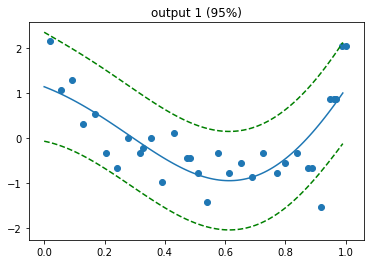

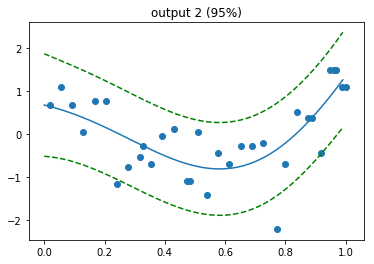

In [12]:
lmc.optimize(optimizer=AdaDelta(verbosity=10))
print(lmc)
print(lmc.noise)
print_diagram(lmc)

In [13]:
import GPy

rbfs = [GPy.kern.RBF(1) for _ in range(nout)]
# not exactly the same since mine is rank-1 only for now
# This is why we need as many kernels as outputs, because we'd be rank-deficient o/w
k = GPy.util.multioutput.LCM(input_dim=1,num_outputs=nout,kernels_list=rbfs)
xss_reshaped = [xs.reshape(-1, 1) for xs in xss]
yss_reshaped = [ys.reshape(-1, 1) for ys in yss]
m = GPy.models.GPCoregionalizedRegression(
    xss_reshaped, yss_reshaped, kernel=k)
m.optimize()
print(m)


Name : gp
Objective : 95.55095597600064
Number of Parameters : 27
Number of Optimization Parameters : 27
Updates : True
Parameters:
  gp.                                    |               value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |  6.47574715553e-151  |      +ve      |        
  sum.ICM0.rbf.lengthscale               |   2.24324956307e-10  |      +ve      |        
  sum.ICM0.B.W                           |              (3, 1)  |               |        
  sum.ICM0.B.kappa                       |                (3,)  |      +ve      |        
  sum.ICM1.rbf.variance                  |   4.86579062907e-06  |      +ve      |        
  sum.ICM1.rbf.lengthscale               |      0.172812533432  |      +ve      |        
  sum.ICM1.B.W                           |              (3, 1)  |               |        
  sum.ICM1.B.kappa                       |                (3,)  |      +ve      |        
  sum.ICM2.rbf.variance                  |   1.1160720142

 /opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


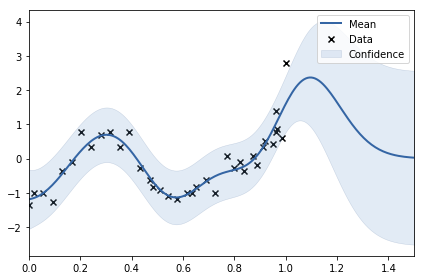

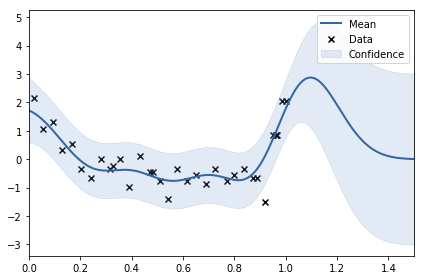

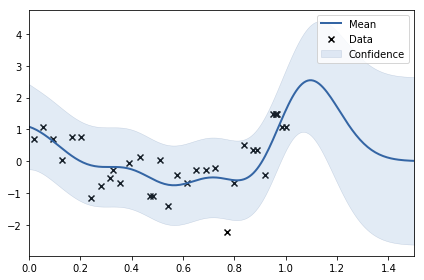

In [14]:
# Plotting code adapted from GPy coregionalization tutorial
# Also 95% confidence

data_rows = np.add.accumulate(n_per_output)
data_rows = np.insert(data_rows, 0, 0)

for i in range(nout):
    m.plot(
        plot_limits=(0, 1.5),
        fixed_inputs=[(1,i)],
        which_data_rows=slice(data_rows[i],data_rows[i + 1]))

In [15]:
# Adding a prior
from runlmc.parameterization.priors import InverseGamma, Gaussian, HalfLaplace

ig = InverseGamma(0.5, 0.5)
lmc.rbf0.inv_lengthscale.set_prior(ig)
lmc.rbf1.inv_lengthscale.set_prior(ig)

n = Gaussian(0, 1)
lmc.a0.set_prior(n)
lmc.a1.set_prior(n)

h = HalfLaplace(1)
lmc.kappa0.set_prior(h)
lmc.kappa1.set_prior(h)

lmc.optimize()

print(lmc)
print(lmc.kappa0)


Name : lmc
Objective : 164.05824647900783
Number of Parameters : 24
Number of Optimization Parameters : 24
Updates : True
Parameters:
  lmc.                  |          value  |  constraints  |         priors        
  rbf0.inv_lengthscale  |  3.36808743573  |      +ve      |  InverseGamma(0.5,0.5)
  rbf1.inv_lengthscale  |   1.9390399912  |      +ve      |  InverseGamma(0.5,0.5)
  rbf2.inv_lengthscale  |   1.6637518737  |      +ve      |                       
  a0                    |         (1, 3)  |               |         N(0, 1)       
  a1                    |         (1, 3)  |               |         N(0, 1)       
  a2                    |         (1, 3)  |               |                       
  kappa0                |           (3,)  |      +ve      |     HalfLaplace(1)    
  kappa1                |           (3,)  |      +ve      |     HalfLaplace(1)    
  kappa2                |           (3,)  |      +ve      |                       
  noise                 |          

In [16]:
# Multilevel prior
from runlmc.parameterization.param import Param

# A param is anything that is unconstrained during the optimization
# We add a param shape such that
# shape ~ IG(0.5, 0.5)
# rbf*.inv_lengthscale ~ IG(0.5, shape)

ig = InverseGamma(0.5, 0.5)
initial_value = 1
shape = Param('shape', initial_value)
lmc.link_parameter(shape) # wire the parameter into the model (otherwise it won't get updated)
shape.set_prior(ig)

ig2 = InverseGamma(0.5, shape)
for il in [lmc.rbf0.inv_lengthscale, lmc.rbf1.inv_lengthscale]:
    il.set_prior(ig2)
    
lmc.optimize(optimizer=AdaDelta())
print(lmc)
print(lmc.kappa0)


Name : lmc
Objective : 161.5001574679286
Number of Parameters : 25
Number of Optimization Parameters : 25
Updates : True
Parameters:
  lmc.                  |           value  |  constraints  |          priors         
  rbf0.inv_lengthscale  |    22.440266042  |      +ve      |  InverseGamma(0.5,shape)
  rbf1.inv_lengthscale  |  0.466642399508  |      +ve      |  InverseGamma(0.5,shape)
  rbf2.inv_lengthscale  |   6.29600395336  |      +ve      |                         
  a0                    |          (1, 3)  |               |          N(0, 1)        
  a1                    |          (1, 3)  |               |          N(0, 1)        
  a2                    |          (1, 3)  |               |                         
  kappa0                |            (3,)  |      +ve      |      HalfLaplace(1)     
  kappa1                |            (3,)  |      +ve      |      HalfLaplace(1)     
  kappa2                |            (3,)  |      +ve      |                         
  nois

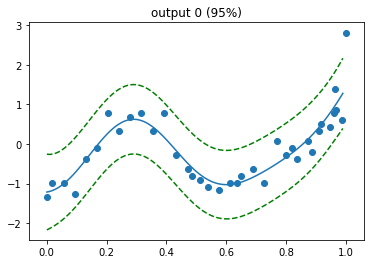

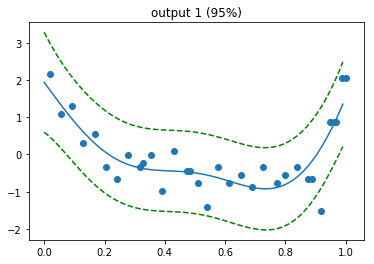

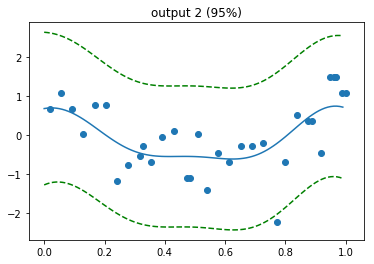

In [17]:
print_diagram(lmc)